In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

Here, we read in the data that we fit in the linear regression lectur: the distance modulus as a function of the recessional velocity. We're going to be fitting a line to this data to derive Hubble's constant.

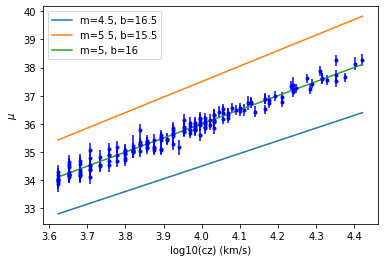

In [2]:
# CHANGE THE BELOW LINE TO POINT TO THE DIRECTORY CONTAINING SNDATA.TXT
path = ''  

# the pandas way: the file is in "fixed-width format" so we use read_fwf
data=pd.read_fwf(path+'sndata.txt')

cz=data['cz'] #already in km/s
mu=data['mu']
sigma_mu=data['sigma_mu']

logv = np.log10(cz)

def line(x, m, b):
    return m*x+b

plt.errorbar(logv,mu,yerr=sigma_mu,fmt='b.')
plt.plot(logv, line(logv, 4.5, 16.5), label='m=4.5, b=16.5')
plt.plot(logv, line(logv, 5.5, 15.5),label='m=5.5, b=15.5')
plt.plot(logv, line(logv, 5, 16),label='m=5, b=16')
plt.xlabel('log10(cz) (km/s)')
plt.ylabel(r'$\mu$')
plt.legend()
plt.savefig('cz_mu.png')
plt.show()

In the below cell, we define the functions that we'll need to run our MCMC analysis. The first of these is the log of the likelihood, which is what emcee uses to determine whether or not the random walk will proceed to the next point. This is just:

$log(\mathcal{L}) = -\frac{\chi^2}{2} = -\frac{1}{2}\Sigma \frac{(f(x,m,b)-\mu)^2}{\sigma_\mu^2}$

In principle, we could also put priors on our parameters, but in this case, we don't need to impose any, so we're just going to return 0.0 as the log of the prior.

The log_probability function just returns the sum of our log_prior and log_likelihood functions.

Note that theta in emcee is an array with a length of the number of dimensions. At every step, the walker arrives at a location in space specified by $\theta=[m_{trial}, b_{trial}]$. It then calculates $\chi^2$ at that location and imposes any priors we may have.

In [4]:
import emcee
import corner

def log_likelihood(theta, mu, sigma_mu, logv):
    m,b = theta
            
    return -0.5 * np.sum((line(logv, m, b)-mu)**2/sigma_mu**2)

def log_prior(theta):
    m,b = theta

    return 0.0

def log_probability(theta, mu, mu_err, logv):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mu, mu_err, logv)

Now that we've set up to run our model, let's actually do so. Normally when running MCMC, one wants to have some idea of the parameters and to start the walkers near them, shifted by some small amount. However, for illustrative purposes, we're actually going to intentionally start our walkers kind of far away from the true values to show how they will all converge to the same part of parameter space after a long enough time.

We are going to use 24 walkers and specify that the dimensionality of our space is 2. The initial positions of the walkers in [m,b] will be [5,16] + some random numbers drawn from a normal distribution. We then run emcee using EnsembleSampler on our log_probability function, giving the args function for mu, sigma_mu, and logv in the order we defined them in for our log_probability function to initialize our sampler, and use the run_mcmc method to run our chains. This should take on the order of 30 seconds to run.

In [5]:
initial = np.array([5, 16])

nwalk = 24
ndim = 2

niters = 1000

pos = initial +  np.random.randn(nwalk, ndim)

sampler = emcee.EnsembleSampler(nwalk, ndim, log_probability, 
                                args=(mu, sigma_mu, logv))

sampler.run_mcmc(pos, niters, progress=True)
print('Done!')

100%|██████████| 1000/1000 [00:19<00:00, 50.55it/s]

Done!


The sampler object will now contain the results of our runs. 

(1000, 24, 2)


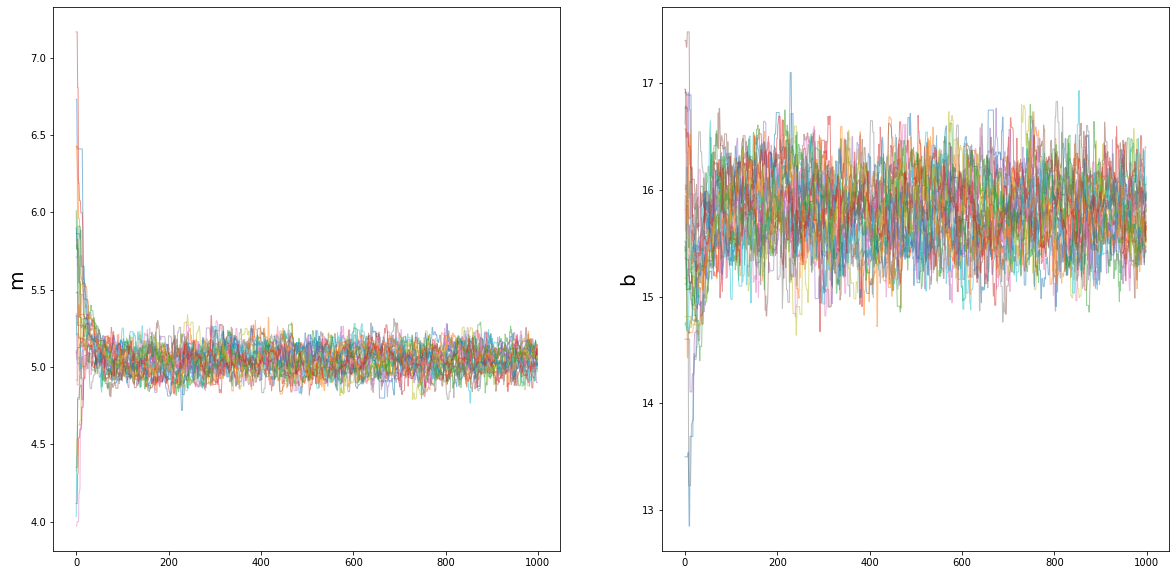

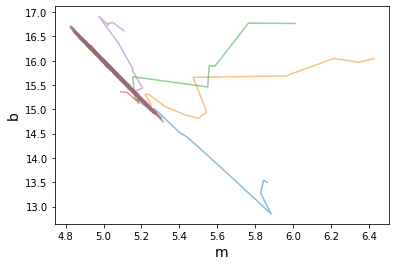

In [6]:
all_samples = sampler.get_chain()

print(np.shape(all_samples))

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for i in range(0,nwalk):
    ax1.plot(all_samples[:,i,0], lw=1, alpha=0.5)
    ax2.plot(all_samples[:,i,1], lw=1, alpha=0.5)
    
ax1.set_ylabel('m', fontsize=20)
ax2.set_ylabel('b', fontsize=20)
plt.show()

plt.plot(all_samples[:,0][:,0], all_samples[:,0][:,1], alpha=0.5)
plt.plot(all_samples[:,1][:,0], all_samples[:,1][:,1], alpha=0.5)
plt.plot(all_samples[:,2][:,0], all_samples[:,2][:,1], alpha=0.5)
plt.plot(all_samples[:,3][:,0], all_samples[:,3][:,1], alpha=0.5)
plt.plot(all_samples[:,4][:,0], all_samples[:,4][:,1], alpha=0.5)
plt.xlabel('m', fontsize=14)
plt.ylabel('b', fontsize=14)
plt.show()


As you can see, the models take some time to "burn in" to to the part of parameter space where they have converged on the values of the model that fit well. How long the burn in takes depends on the number of parameters, where you choose to start the parameters, and how well the model fits the data. There isn't a short answer for how long this will take, but you will want to throw away the data from before the models have converged. Looking at the above plots, we can see that this simple model converges very quickly. However, we can be extremely conservative and throw away the first 100 steps of ever walk to make sure that we are not using any of the burn in points in our posterior.

In the cell below, we get the chain again, this time getting a flattened version (collapsing all the chains into a single measurement). We then use the corner.corner plotting function to create a plot that shows the 2D histogram of our parameters, as well as the 1D distributions as well. I also plot the median values of both parameters as a star.

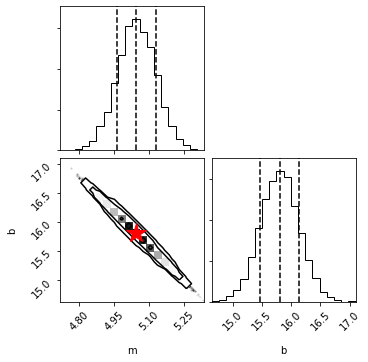

In [7]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
m_samples = flat_samples[:,0]
b_samples = flat_samples[:,1]


fig = corner.corner(flat_samples, levels=[0.68,0.95,0.99], 
                    labels=['m', 'b'], quantiles=[0.16,0.5,0.84])
ax = fig.axes[2]
ax.plot(np.median(m_samples), np.median(b_samples), '*', ms=20, color='red')
plt.show()

What we're actually after is constraints on the Hubble constant, so to get those, let's just transform our measurements of the intercept using the conversion we defined in our linear regression talk. We can then report our constraints on the Hubble constant using the median and 1-sigma values of our histogram.

H0 16th, 50th, and 84th Percentiles
[59.47149961 69.02355127 80.3846594 ]


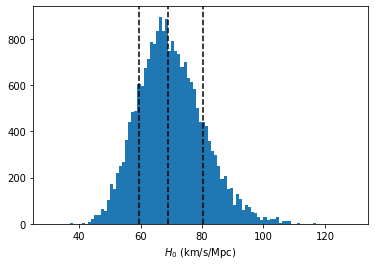

In [8]:
def int_to_H0(b):
    return(10**(-0.2*b) * 10**5)


h0_samples = int_to_H0(b_samples)

print('H0 16th, 50th, and 84th Percentiles')
print(np.percentile(h0_samples, [16,50,84]))

plt.hist(h0_samples, bins=np.arange(30,130,1))
plt.axvline(np.median(h0_samples), ls='--', color='black')
plt.axvline(np.percentile(h0_samples, 16), ls='--', color='black')
plt.axvline(np.percentile(h0_samples, 84), ls='--', color='black')
plt.xlabel(r'$H_0$ (km/s/Mpc)')
plt.show()

We can also sample randomly from our distributions to visually see how well we fit our model. To do this, we're just going to generate 500 random draws from our flat m and b samples and shade the 2-sigma region the models fall in. We very tightly constrain our linear model here.

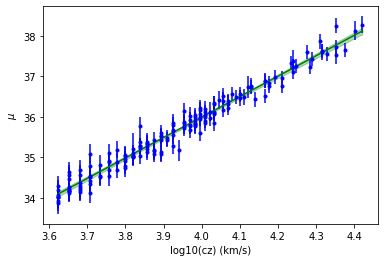

In [9]:
rand_indices = np.random.randint(0,len(m_samples), size=(500,1))
mu_model_arr = []
for index in rand_indices:
    index = index[0]
    mu_model_arr.append(line(logv, m_samples[index], b_samples[index]))


plt.errorbar(logv,mu,yerr=sigma_mu, fmt='b.')

plt.plot(logv, np.median(mu_model_arr, axis=0), color='green')
plt.fill_between(logv, np.percentile(mu_model_arr, 2.5, axis=0),
                np.percentile(mu_model_arr, 97.5, axis=0), color='green', alpha=0.3)
plt.xlabel('log10(cz) (km/s)')
plt.ylabel(r'$\mu$')
plt.show()

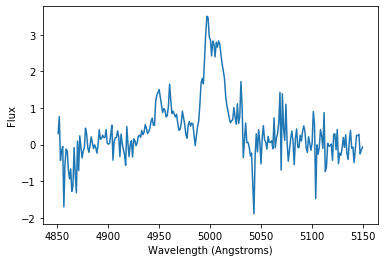

In [10]:
emline = np.genfromtxt('emline.txt')
wl = emline[:,0]
flux = emline[:,1]

plt.plot(wl, flux)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.show()

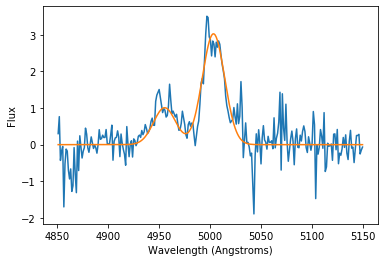

In [11]:
from scipy.optimize import curve_fit

def gaussian_OIII(lam,a,mu,sigma):
    return a*(np.exp(-(lam-mu)**2/sigma**2) + 0.333*np.exp(-(lam-mu+48)**2/sigma**2))


params, covar = curve_fit(gaussian_OIII, wl, flux, p0=[1, 5007, 10])
a, mu, sigma = params

plt.plot(wl, flux)
plt.plot(wl, gaussian_OIII(wl, a, mu, sigma))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.show()

In [12]:
def log_likelihood(theta, flux, wl):
    a, mu, sigma = theta
    
    flux_model = gaussian_OIII(wl, a, mu, sigma)
    
    return -0.5 * np.sum((flux_model-flux)**2)

def log_prior(theta):
    a, mu, sigma = theta
    
    if a<0:
        return -np.inf
    if sigma<0:
        return -np.inf
    
    return 0.0

def log_probability(theta, flux, wl):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, flux, wl)

In [13]:
initial = np.array([1, 5007, 10])

nwalk = 48
ndim = 3

niters = 1000

pos = initial +  1e-4*np.random.randn(nwalk, ndim)

sampler = emcee.EnsembleSampler(nwalk, ndim, log_probability, 
                                args=(flux, wl))

sampler.run_mcmc(pos, niters, progress=True)
print('Done!')

100%|██████████| 1000/1000 [00:03<00:00, 326.27it/s]

Done!


(1000, 48, 3)


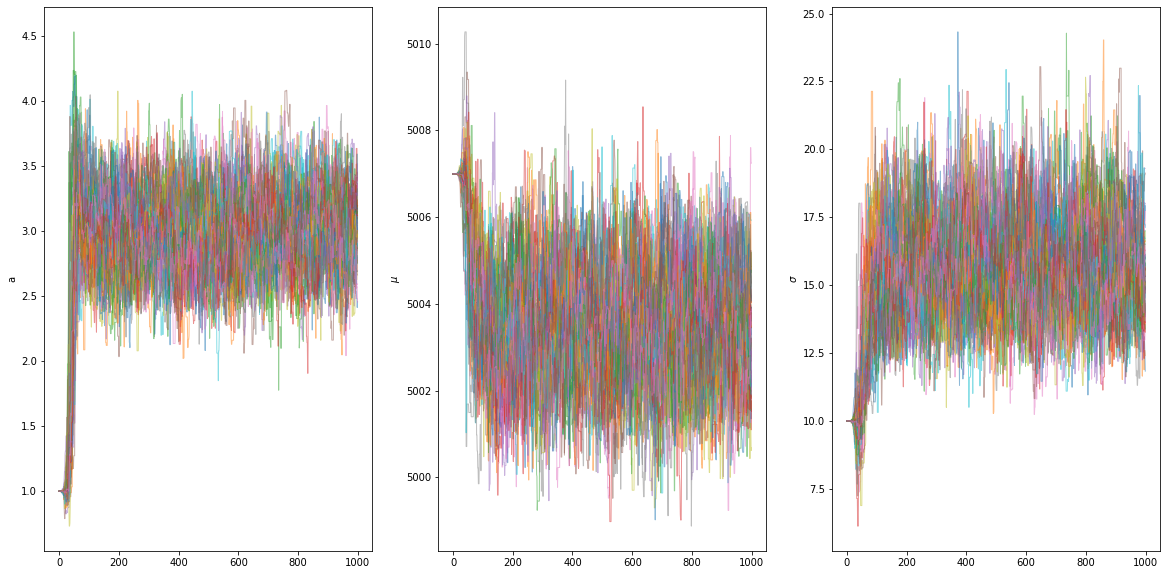

In [14]:
all_samples = sampler.get_chain()

print(np.shape(all_samples))

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for i in range(0,nwalk):
    ax1.plot(all_samples[:,i,0], lw=1, alpha=0.5)
    ax2.plot(all_samples[:,i,1], lw=1, alpha=0.5)
    ax3.plot(all_samples[:,i,2], lw=1, alpha=0.5)

ax1.set_ylabel('a')
ax2.set_ylabel(r'$\mu$')
ax3.set_ylabel(r'$\sigma$')

plt.show()

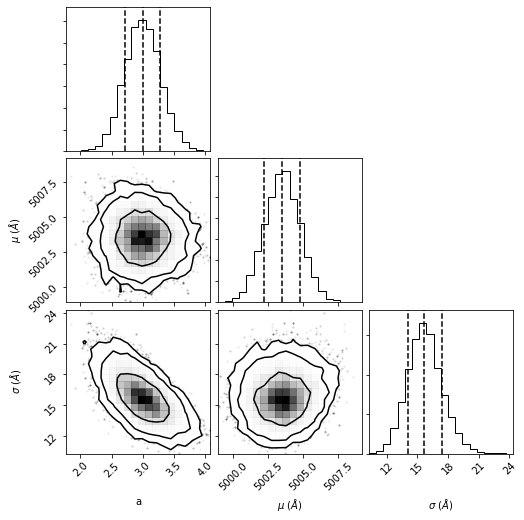

In [15]:
flat_samples = sampler.get_chain(discard=200, thin=1, flat=True)
a_samples = flat_samples[:,0]
mu_samples = flat_samples[:,1]
sigma_samples = flat_samples[:,2]

fig = corner.corner(flat_samples, levels=[0.68,0.95,0.99], 
                    quantiles=[0.16,0.5,0.84], labels=['a', r'$\mu \ (\AA)$', '$\sigma \ (\AA)$'])
plt.savefig('/Users/davidsetton/Desktop/corner.pdf')

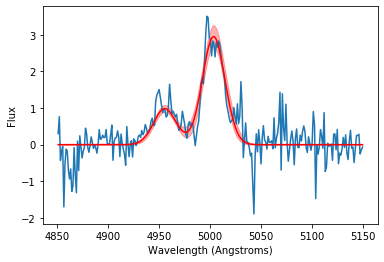

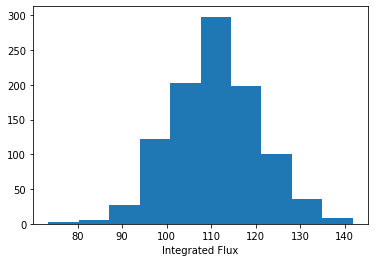

In [16]:
rand_indices = np.random.randint(0,len(m_samples), size=(1000,1))
flux_model_arr = []

integrated_flux_line = []

for index in rand_indices:
    index = index[0]
    flux_model_arr.append(gaussian_OIII(wl, a_samples[index], mu_samples[index], sigma_samples[index]))
    integrated_flux_line.append(np.trapz(gaussian_OIII(wl, a_samples[index], mu_samples[index], sigma_samples[index]),
                                   wl))

plt.plot(wl, flux)
plt.plot(wl, np.median(flux_model_arr, axis=0), color='red')
plt.fill_between(wl, np.percentile(flux_model_arr, 16, axis=0), np.percentile(flux_model_arr, 84, axis=0), 
                color='red', alpha=0.3)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.show()

plt.hist(integrated_flux_line, bins=10)
plt.xlabel('Integrated Flux')
plt.show()